<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  PCA para estudiar la dimensionalidad de la calidad de vida en las ciudades 

En este caso-taller vamos a aplicar PCA en el estudio de calidad de vida en diferentes ciudades. Para ello, haremos uso de los datos que surgen del Almanaque Calificado de Lugares. En este Almanaque Boyer y Savageau calificaron 329 ciudades de acuerdo con los siguientes nueve criterios:

   - Clima y Terreno
   - Alojamiento
   - Cuidado de la salud y el medio ambiente
   - Crimen
   - Transporte
   - Educación
   - Artes
   - Recreación
   - Economía 

Con tantas variables disponibles, la matriz de dispersión puede resultar muy grande para estudiarla e interpretarla adecuadamente. Habría demasiadas correlaciones bivariadas entre las variables a considerar. Para interpretar los datos de una forma más significativa es necesario reducir el número de variables a unas pocas dimensiones, y para ello en este ejercicio recurriremos al análisis de componentes principales. 
 

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo junto al archivo de soporte.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en la misma ruta de acceso del cuaderno, por ejemplo: `data/archivo_de_soporte.csv`.

## Integrantes

Grupo 29

|**Nombre**|**Email**|
|---|---|
|Jaramillo Simon|s.jaramillo3@uniandes.edu.co|
|Mendoza Canales Hubert Ronald|h.mendozac@uniandes.edu.co|
|Montero Ramirez Daniel Eduardo|de.montero@uniandes.edu.co|

## Desarrollo


#### Config

##### Carga de Bibliotecas

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

# python
import os
import sys
import csv
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from pathlib import Path

from numpy.linalg import matrix_power

# rutas absolutas
here: Path = Path.cwd().absolute()
data: Path = here / 'data'
input: str = str(data / 'lugares.csv')
output: str = str(data / 'archivo_de_soporte.csv')

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# paquete pca
from pca import pca

# typings
from pandas import DataFrame as PandasDF
from typing import List

# setup
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('max_colwidth', None)
# decimals
np.set_printoptions(precision=6)

##### Información de Sesión

In [3]:
session_info.show(html=False)

-----
ipykernel           6.29.5
ipywidgets          8.1.5
keras               2.15.0
matplotlib          3.8.0
numpy               1.26.4
pandas              1.5.3
pca                 2.10.0
pyspark             3.5.2
seaborn             0.13.2
session_info        v1.0.1
sklearn             1.6.1
tensorflow          2.15.0
torch               2.5.1+cu121
xarray              2023.6.0
-----
IPython             8.32.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.2.5
notebook            7.0.8
-----
Python 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.26100-SP0
-----
Session information updated at 2025-08-10 00:52


### utils

In [4]:
# utils
def plot_boxplot(df: PandasDF)->None:
    for col in df:
        plt.figure(figsize=(17,1), dpi=320)
        sns.boxplot(data=df, x=col)
        plt.title(col, size=14)
        plt.xlabel('')
    
    return

### 1. Carga de datos

En la carpeta `data` se encuentra el archivo `lugares.csv` cargue estos datos en su *cuaderno*.

In [18]:
# Utilice este espacio para escribir el código.

In [5]:
df = pd.read_csv(input, sep=',', encoding='utf-8')
df.set_index('Ciudad', inplace=True)
df.head(5)

,Clima y Terreno,Alojamiento,Cuidado de la salud y el medio ambiente,Crimen,Transporte,Educación,Artes,Recreación,Economía
Ciudad,,,,,,,,,
"Abilene,TX",521,6200,237,923,4031,2757,996,1405,7633
"Akron,OH",575,8138,1656,886,4883,2438,5564,2632,4350
"Albany,GA",468,7339,618,970,2531,2560,237,859,5250
"Albany-Schenectady-Troy,NY",476,7908,1431,610,6883,3399,4655,1617,5864
"Albuquerque,NM",659,8393,1853,1483,6558,3026,4496,2612,5727


Se valida si existen datos nulos en cada variable porque ello podría devenir en eignvalores negativos

<a 
    href="https://stats.stackexchange.com/questions/315297/negative-eigenvalues-in-principle-component-analysis-in-the-presence-of-missing" 
    target="_blank">
        Negative eigenvalues in principle component analysis in the presence of missing data
</a>

In [23]:
(
    df.isnull()
    .sum()
    .to_frame()
    .rename(columns={0: 'Missing Values'})
)

,Missing Values
Clima y Terreno,0
Alojamiento,0
Cuidado de la salud y el medio ambiente,0
Crimen,0
Transporte,0
Educación,0
Artes,0
Recreación,0
Economía,0


### 2.  Análisis descriptivo de las variables. 

Para el análisis descriptivo haga uso de estadísticas descriptivas y matrices de correlación. Indique además cuantas gráficas de dispersión bivariadas debería examinar con este número de variables. 

Explique porqué es importante conocer las estadísticas descriptivas y como contribuyen al ejercicio posterior de Análisis de Componentes Principales.
 
Tenga en cuenta que para las variables, a excepción de la alojamiento y crimen, cuanto mayor sea el puntaje, mejor. Por el contrario; para alojamiento y crimen, mientras más bajo sea el puntaje, mejor. También, mientras algunas comunidades podrían calificar mejor en las artes, otras podrían calificar mejor en otras áreas como tener una tasa de criminalidad más baja y buenas oportunidades educativas.

In [22]:
# Utilice este espacio para escribir el código.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, Abilene,TX to Yuba-City,CA
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Clima y Terreno                          329 non-null    int64
 1   Alojamiento                              329 non-null    int64
 2   Cuidado de la salud y el medio ambiente  329 non-null    int64
 3   Crimen                                   329 non-null    int64
 4   Transporte                               329 non-null    int64
 5   Educación                                329 non-null    int64
 6   Artes                                    329 non-null    int64
 7   Recreación                               329 non-null    int64
 8   Economía                                 329 non-null    int64
dtypes: int64(9)
memory usage: 25.7+ KB


In [27]:
# Estadísticas descriptivas.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Clima y Terreno,329.0,538.732523,120.808259,105.0,480.0,542.0,592.0,910.0
Alojamiento,329.0,8346.559271,2385.262622,5159.0,6760.0,7877.0,9015.0,23640.0
Cuidado de la salud y el medio ambiente,329.0,1185.738602,1003.002036,43.0,583.0,833.0,1445.0,7850.0
Crimen,329.0,961.054711,357.154186,308.0,707.0,947.0,1156.0,2498.0
Transporte,329.0,4210.082067,1451.179240,1145.0,3141.0,4080.0,5205.0,8625.0
Educación,329.0,2814.887538,320.792953,1701.0,2619.0,2794.0,3012.0,3781.0
Artes,329.0,3150.884498,4642.283738,52.0,778.0,1871.0,3844.0,56745.0
Recreación,329.0,1845.957447,807.888171,300.0,1316.0,1670.0,2176.0,4800.0
Economía,329.0,5525.364742,1084.468523,3045.0,4842.0,5384.0,6113.0,9980.0


Text(0, 0.5, 'Atributos')

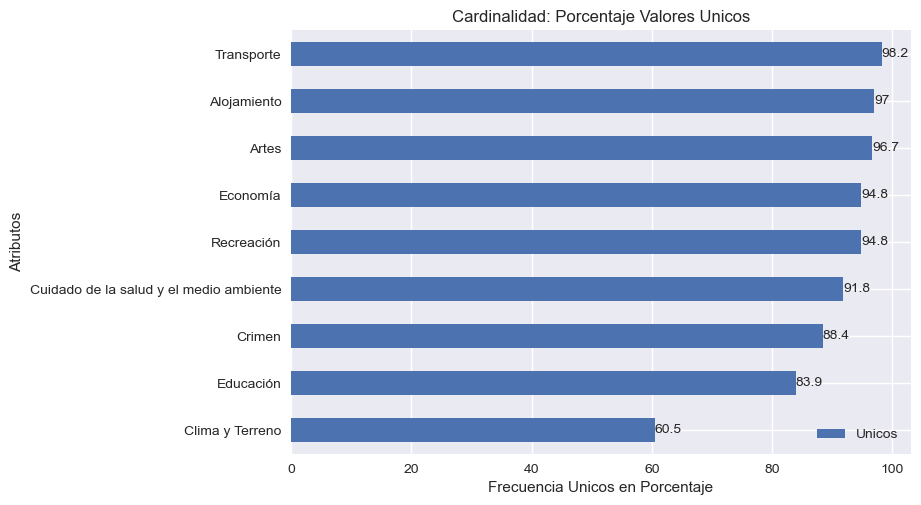

In [9]:
variables_numericas: List[str] = \
    df.select_dtypes(['int64', 'float64']).columns.tolist()

df_stage: PandasDF = df.copy()
numero_observaciones: int = df_stage.shape[0]

# no se incluye el salario variables_numericas[:-1]
unicos: List = [
    round(len(df_stage[variable].unique())*100 / numero_observaciones,1)
    for variable in variables_numericas
]
df_plot: PandasDF = (
    pd.DataFrame({
            'VarNum':variables_numericas, 
            'Unicos':unicos
        })
        .sort_values(by='Unicos')
)
ax = df_plot.plot.barh(y='Unicos', x='VarNum')

for container in ax.containers:
    ax.bar_label(container)

ax.set_title('Cardinalidad: Porcentaje Valores Unicos')
ax.set_xlabel('Frecuencia Unicos en Porcentaje')
ax.set_ylabel('Atributos')

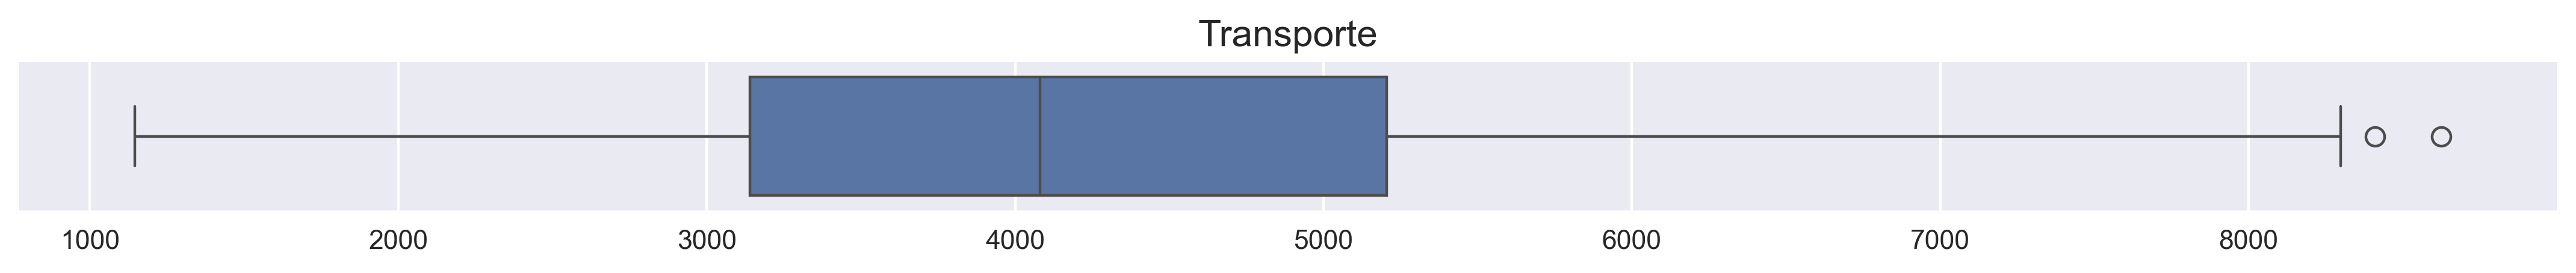

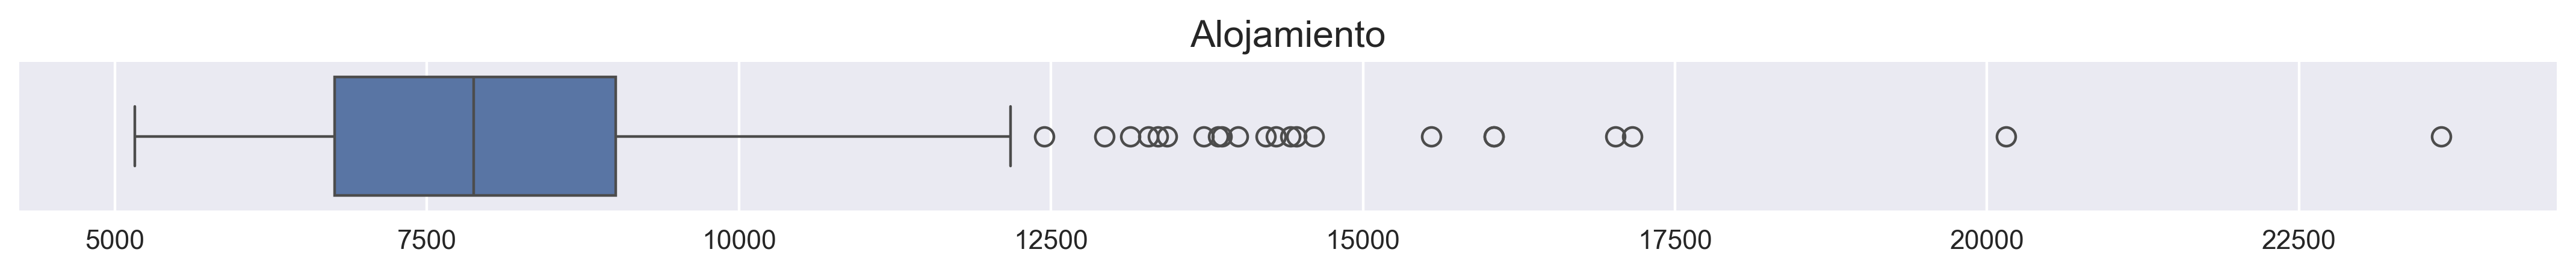

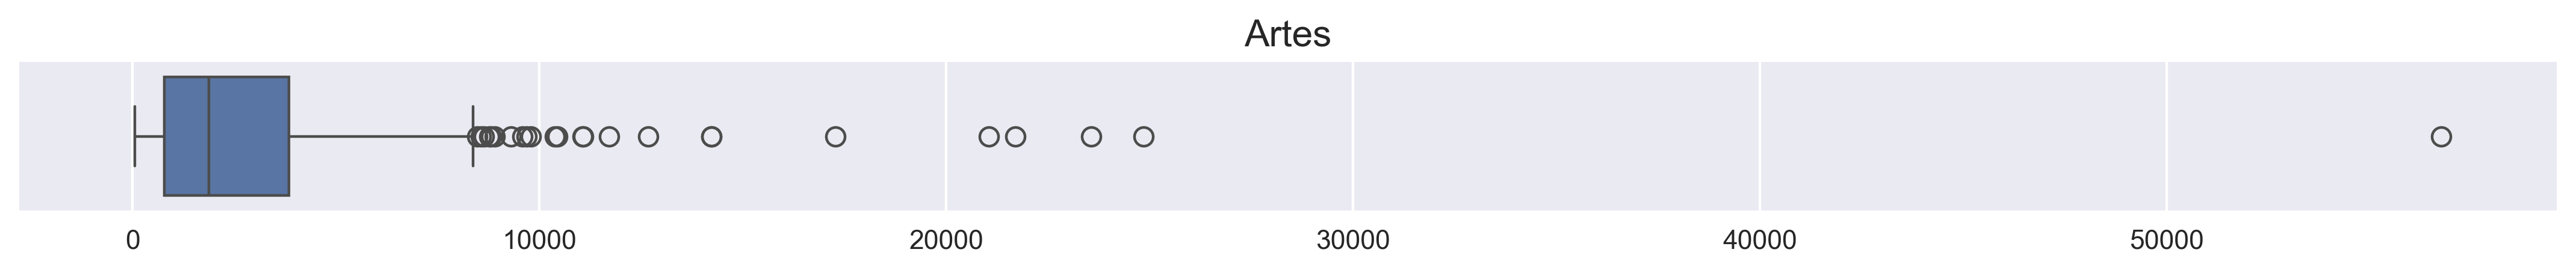

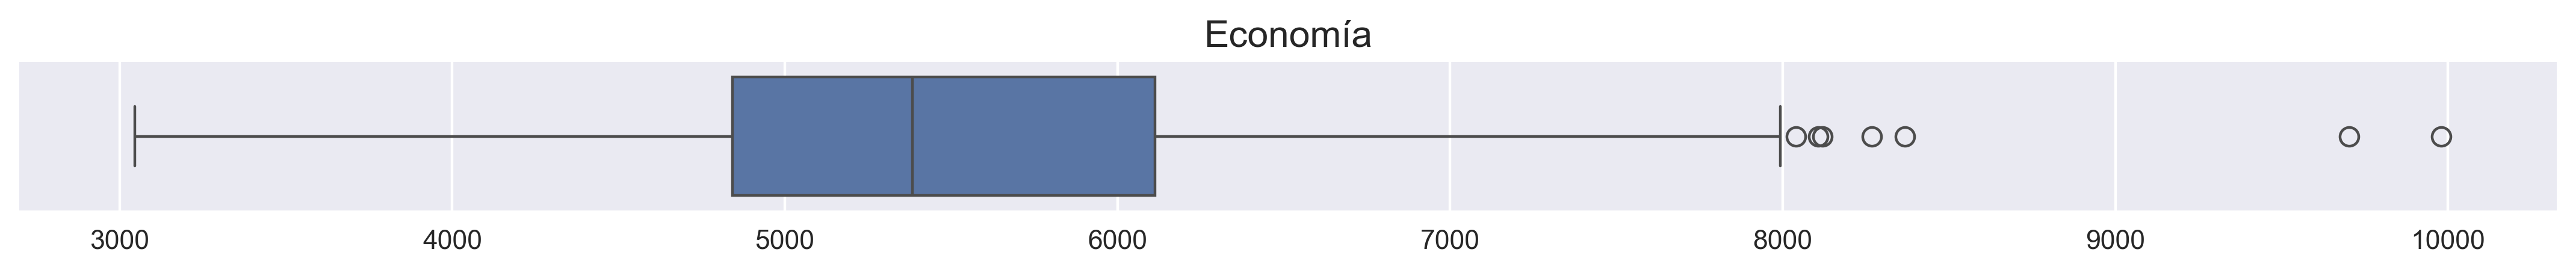

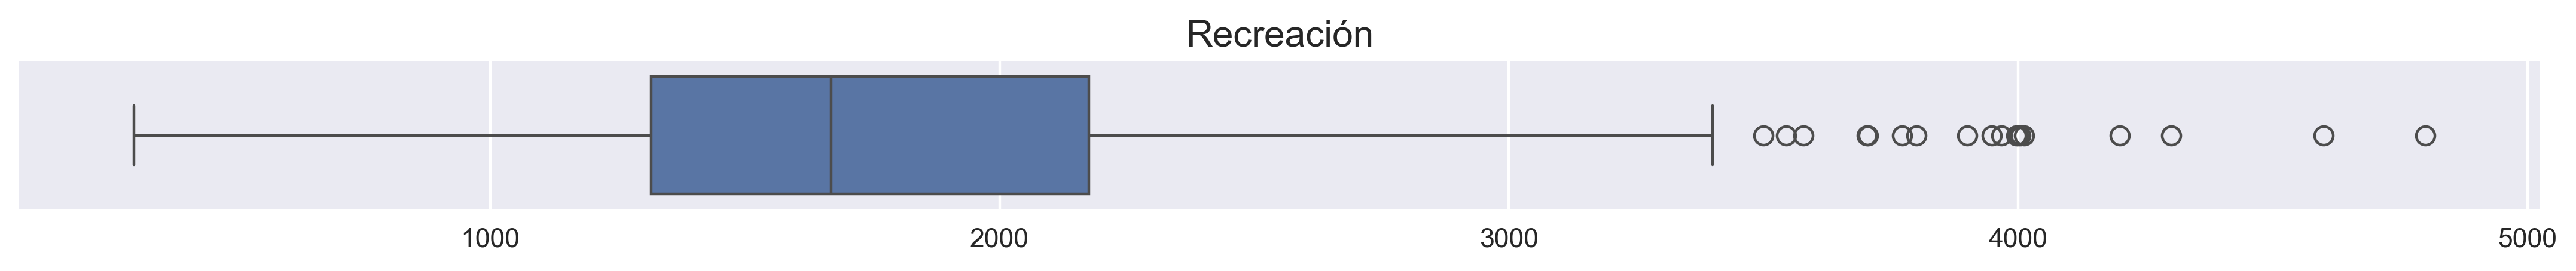

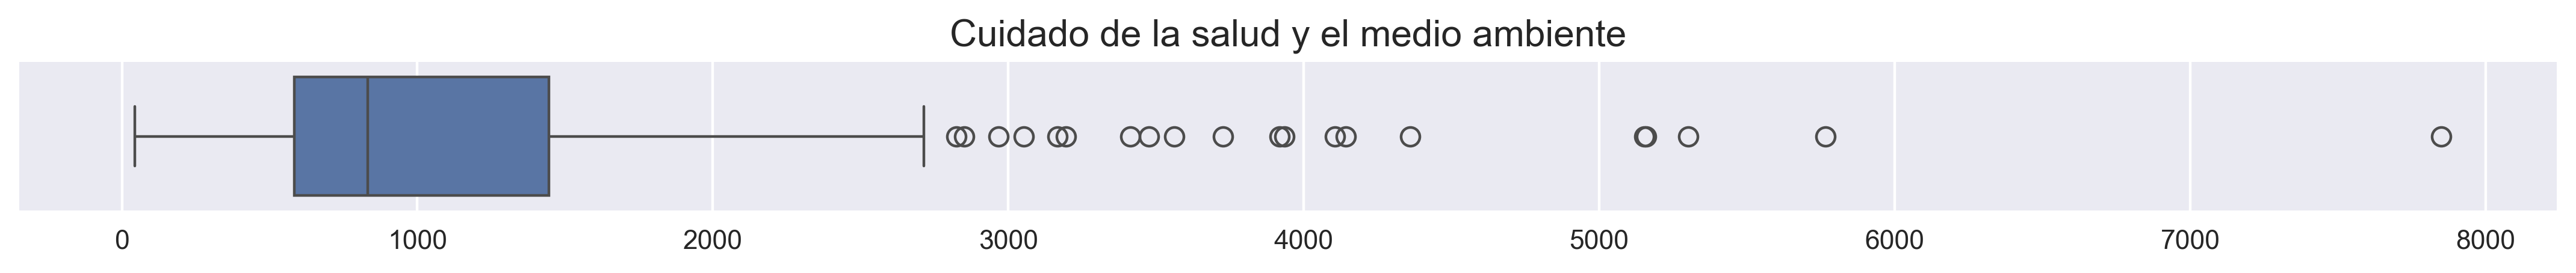

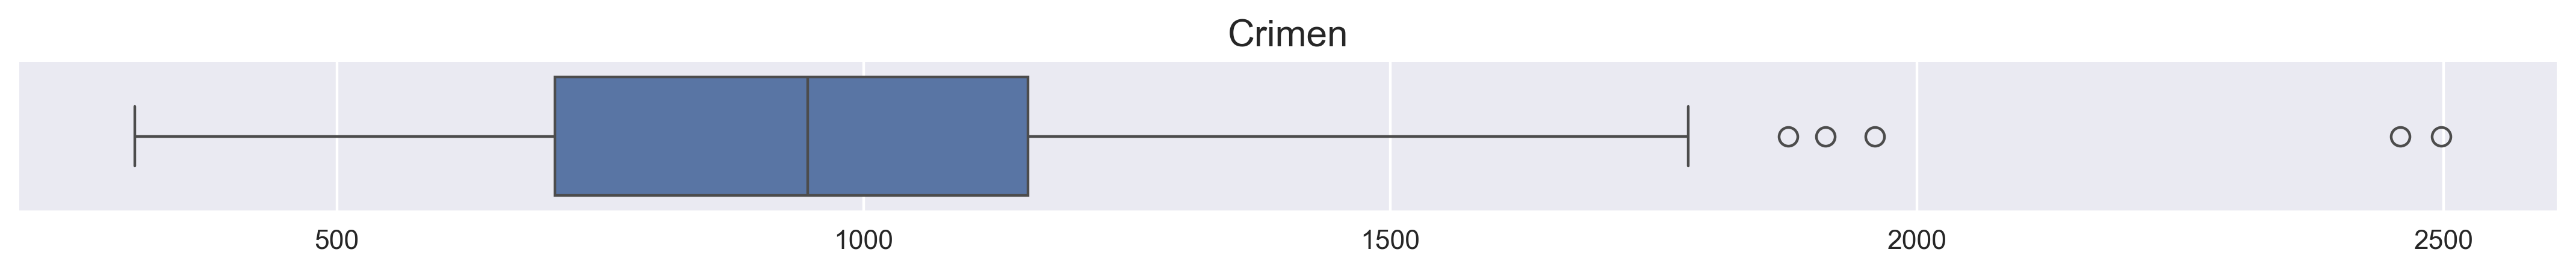

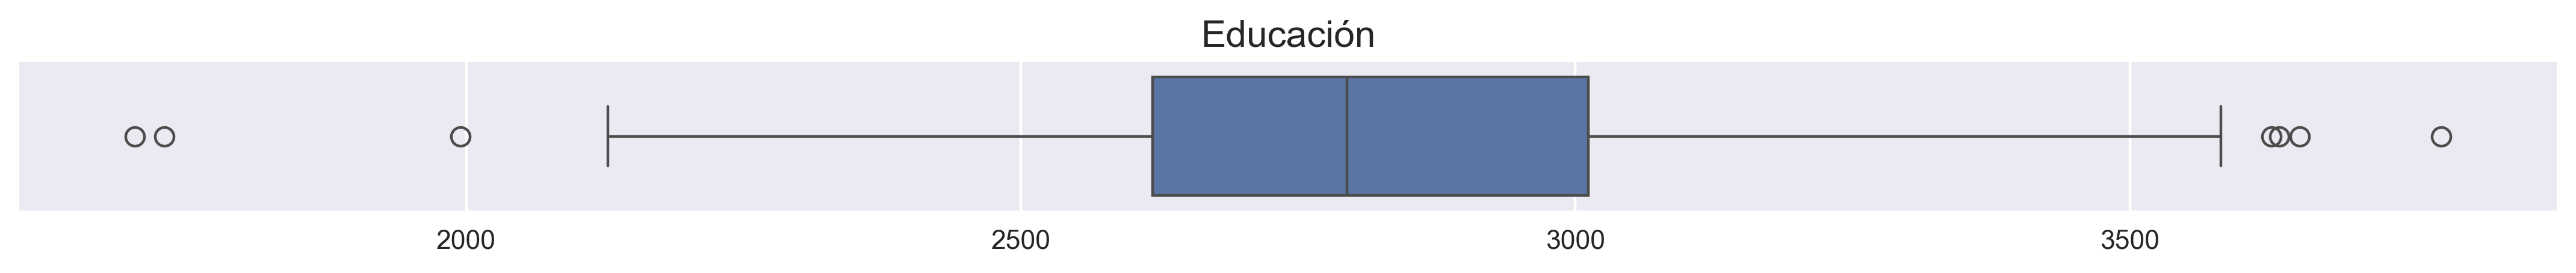

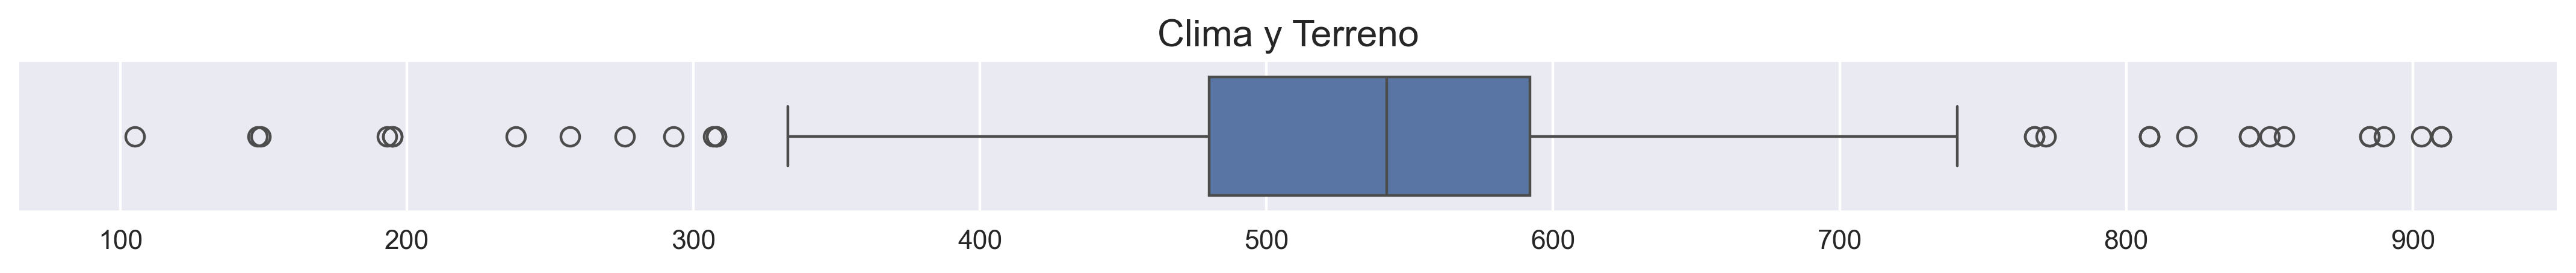

In [11]:
# se usa df_plot porque ya estan ordenadas por cardinalidad
rank_frec_atributos: List = df_plot.VarNum.tolist()[::-1]
plot_boxplot(df_stage.loc[:, rank_frec_atributos])

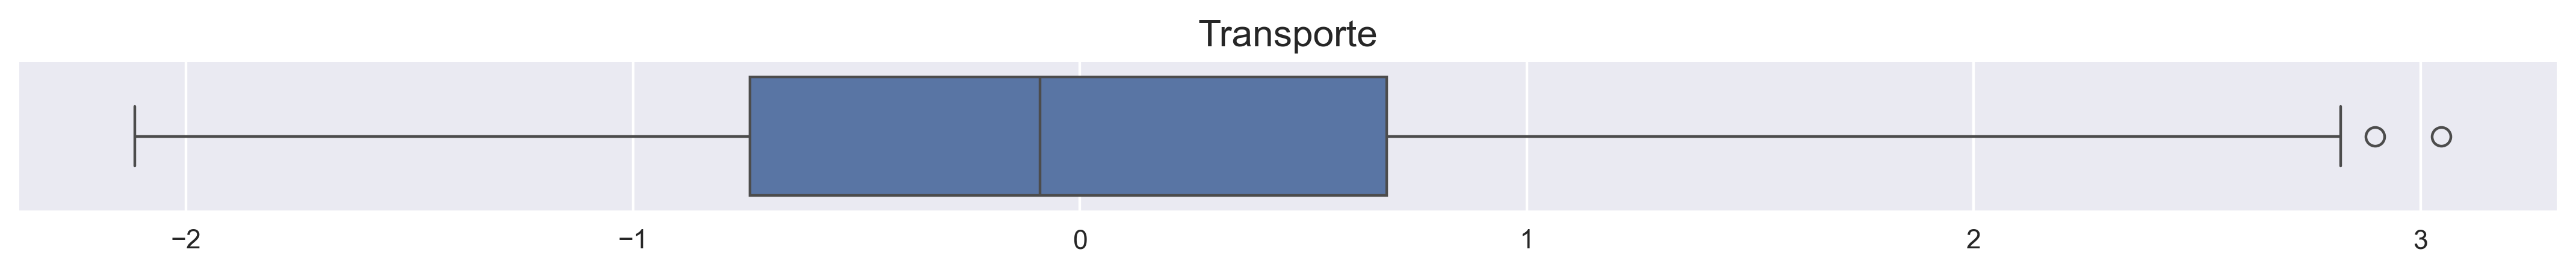

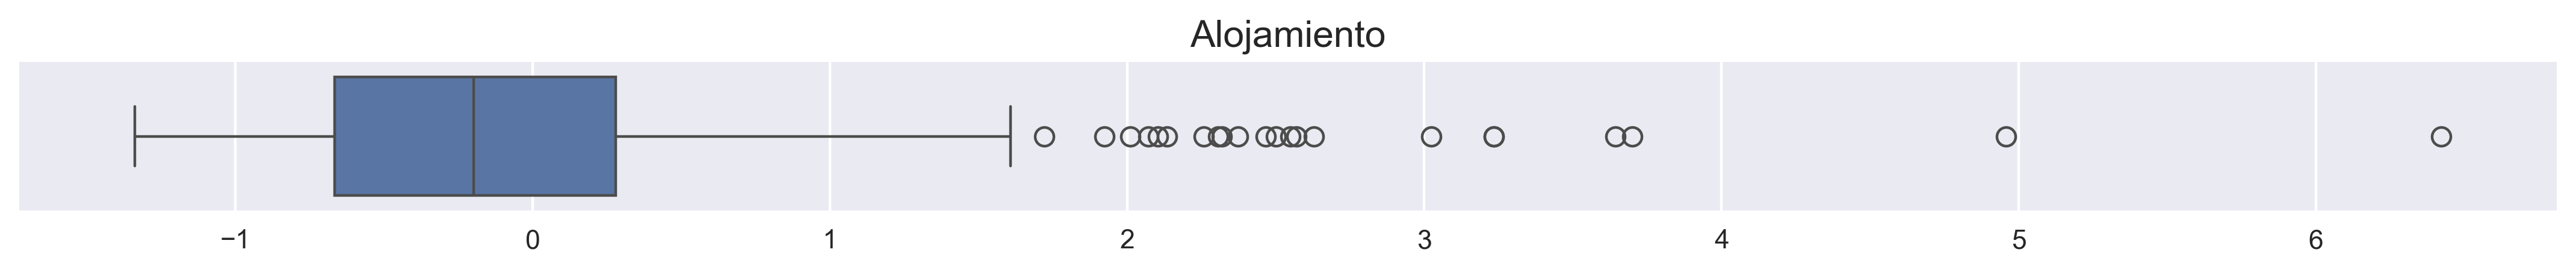

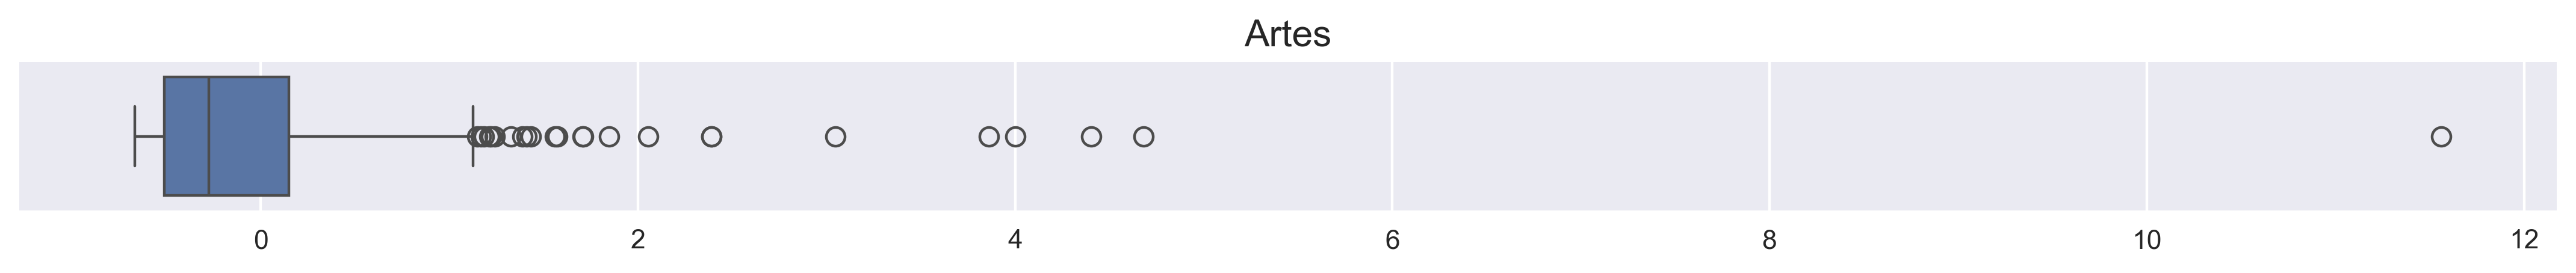

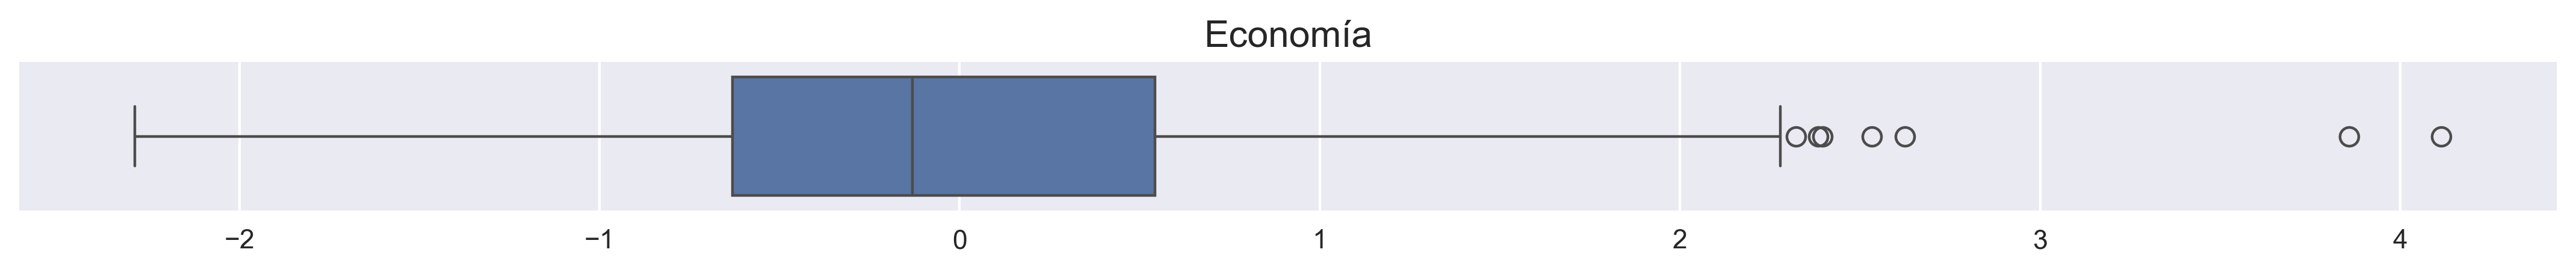

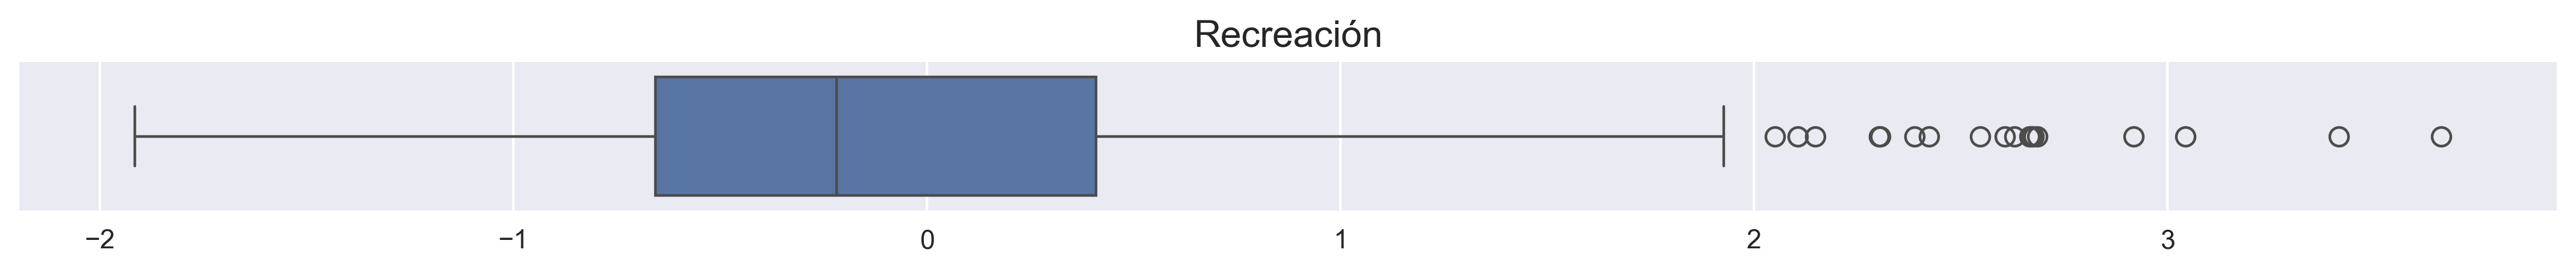

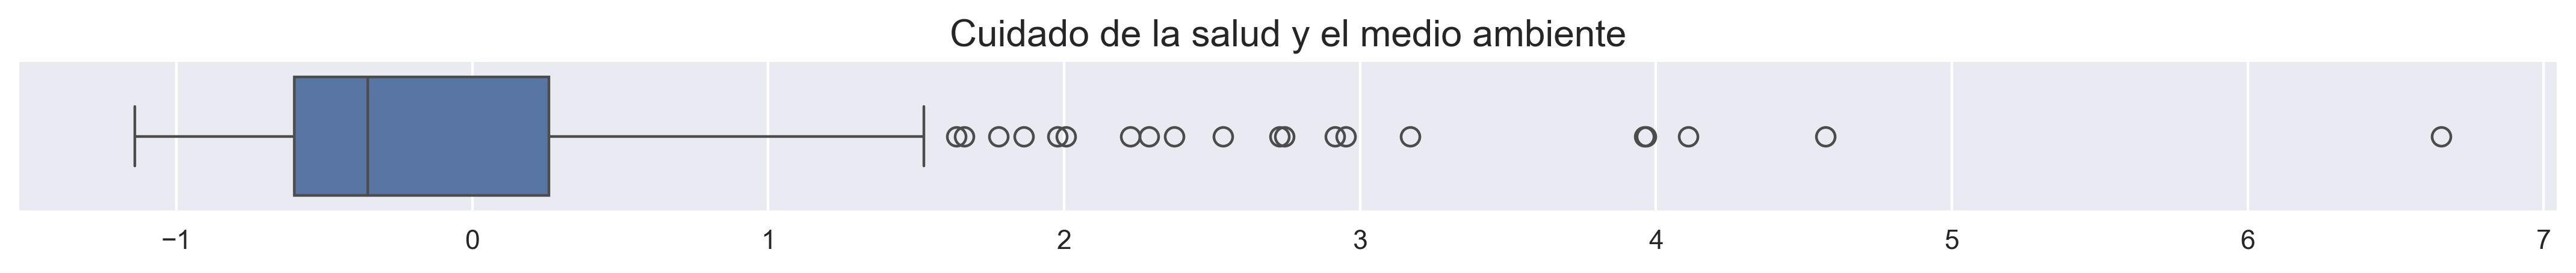

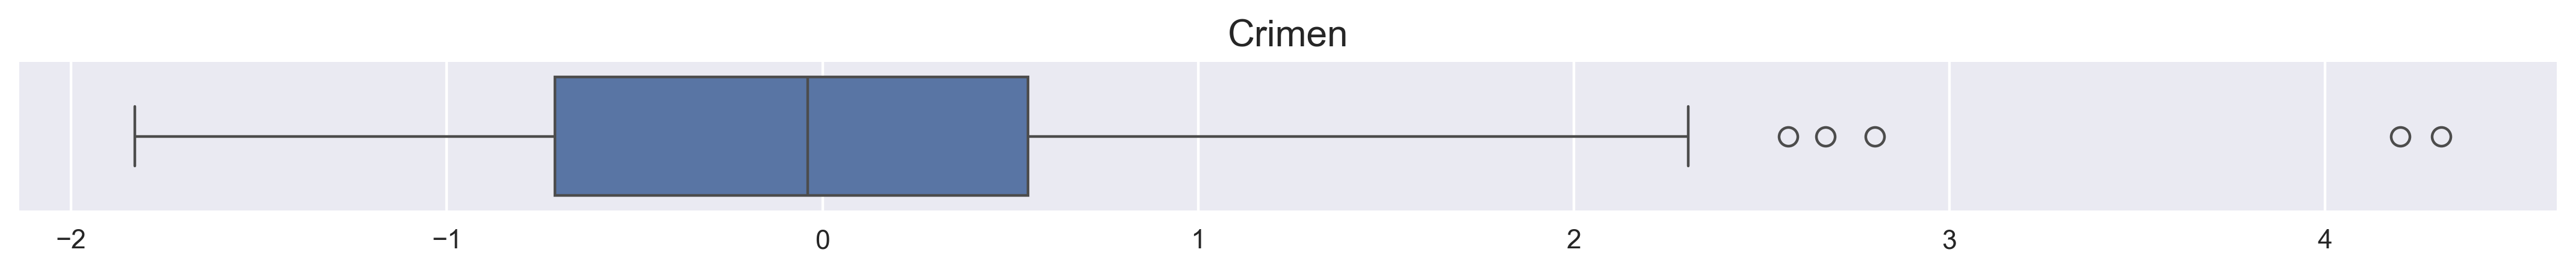

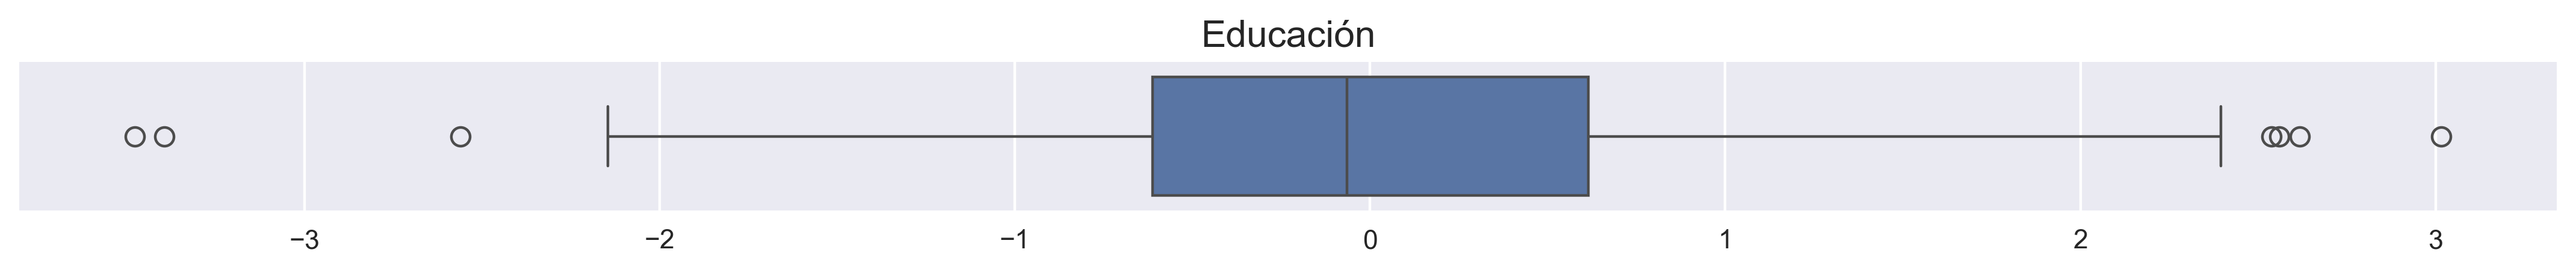

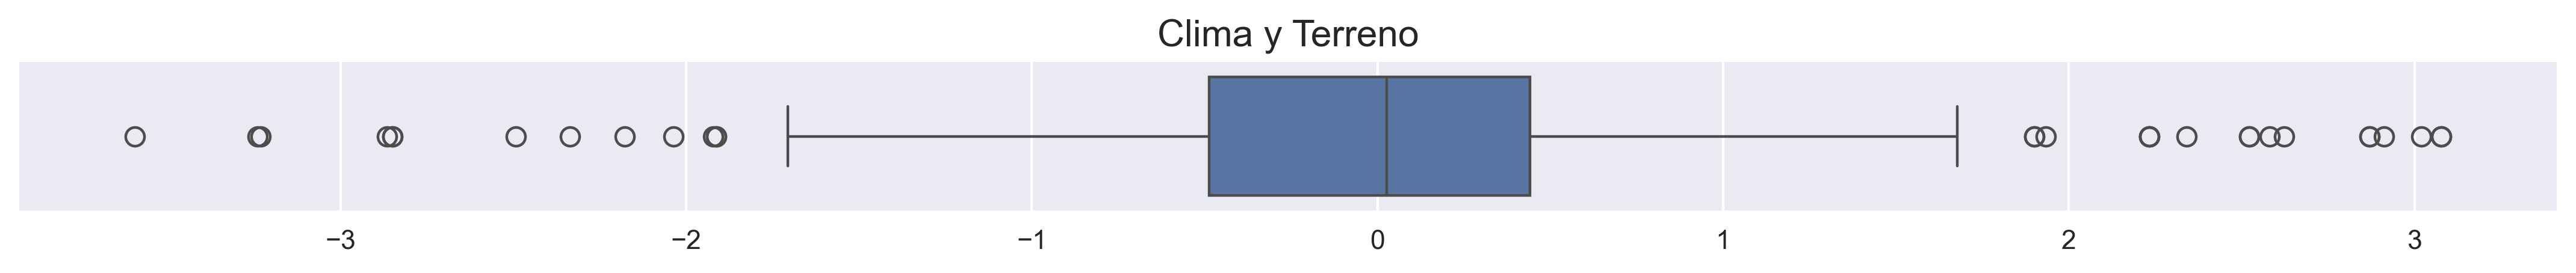

In [13]:
# Plotear escalado (no forma parte del ETL - limpieza de datos)
Xs = df_stage.loc[:, rank_frec_atributos].to_numpy()
scaler = StandardScaler()
scaler.fit(Xs)
XEscalados = scaler.transform(Xs)

df_stage_escalado = pd.DataFrame(XEscalados, columns=rank_frec_atributos)
plot_boxplot(df_stage_escalado)

Al aplicar el scalado con la instancia `StandardScaler` de sklearn, la simetria positiva se mantiene, pero la distancia relativa entre estos outlayers y las medidas centrales disminuyen.

Otra forma de escalar los datos para hacerlos más `gaussianos`, sería usar el método `box-cox` pero dado que existen valores negativos en los datos, no sería posible al tratar de instanciar el [`PowerTransformer` de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#rf3e1504535de-2).

No obstante, <ins>solo se proporciona el código con el método `yeo-johnson`<ins> 

```python
    from sklearn.preprocessing import PowerTransformer

    # no se usa box-cox porque es para datos estrictamente positivos
    Xs = df_stage.loc[:, rank_frec_atributos].to_numpy()
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    pt.fit(Xs)
    Xgaussianos = pt.transform(Xs)

    df_stage_gaussiano = pd.DataFrame(Xgaussianos, columns=rank_frec_atributos)
    plot_boxplot(df_stage_gaussiano)
```

Para efectos de este entregable se va emplear `StandardScaler` de sklearn para escalar los datos

> Nota: Un escalamiento centrado (`gaussiano`) quizás hace más sentido para un modelo de clasificación del tipo `Naïve Bayes classifier` (supervisado) donde no es lo mismo subir que bajar.

In [15]:
# Matriz de correlación
correlation_matrix = df.corr()
correlation_matrix

,Clima y Terreno,Alojamiento,Cuidado de la salud y el medio ambiente,Crimen,Transporte,Educación,Artes,Recreación,Economía
Clima y Terreno,1.000000,0.386291,0.213303,0.192387,0.079120,0.064520,0.226974,0.213509,-0.100083
Alojamiento,0.386291,1.000000,0.453010,0.134222,0.271922,0.197934,0.448568,0.422288,0.269433
Cuidado de la salud y el medio ambiente,0.213303,0.453010,1.000000,0.304659,0.470317,0.490234,0.865796,0.325397,0.069271
Crimen,0.192387,0.134222,0.304659,1.000000,0.286578,0.074416,0.389483,0.344627,0.259995
Transporte,0.079120,0.271922,0.470317,0.286578,1.000000,0.335992,0.464806,0.364716,0.059247
Educación,0.064520,0.197934,0.490234,0.074416,0.335992,1.000000,0.373279,0.077807,0.119700
Artes,0.226974,0.448568,0.865796,0.389483,0.464806,0.373279,1.000000,0.378659,0.075673
Recreación,0.213509,0.422288,0.325397,0.344627,0.364716,0.077807,0.378659,1.000000,0.173531
Economía,-0.100083,0.269433,0.069271,0.259995,0.059247,0.119700,0.075673,0.173531,1.000000


[Text(0.5, 1.0, 'Matriz de Correlación')]

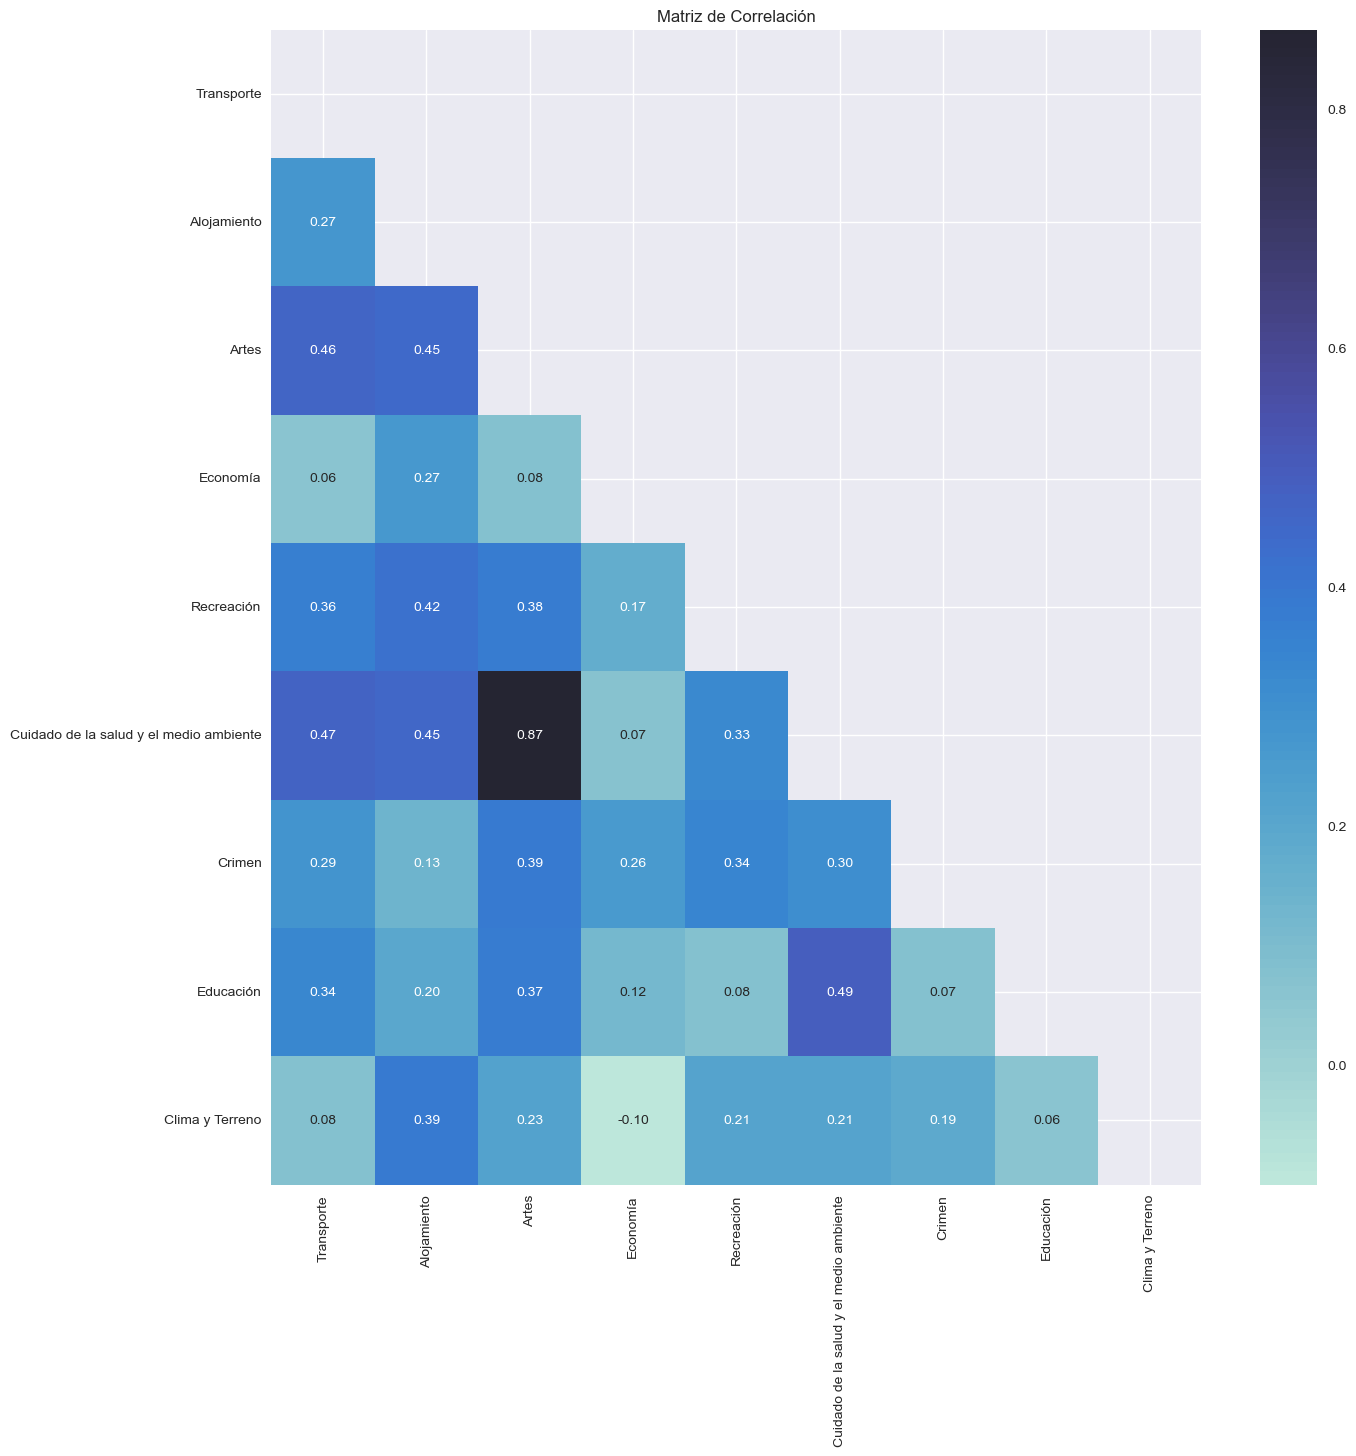

In [17]:
# Adaptado de
# https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap
# se suprime la parte superior de la matriz de correlación así como la diagonal 
# al ser todos los valores iguales a 1

plt.figure(figsize=(15, 15))
correlation_matrix = df_stage.loc[:, rank_frec_atributos].corr()
matrix = np.triu(correlation_matrix)

sns.heatmap(
    correlation_matrix,
    annot=True, 
    mask=matrix,
    center=1,
    fmt=".2f"
).set(title='Matriz de Correlación')

In [19]:
# Número de gráficas de dispersión bivariadas
num_variables = df.shape[1]
num_scatter_plots = math.comb(num_variables, 2)
print(
    f"Se deberían examinar {num_scatter_plots} "
    f"gráficas de dispersión bivariadas."
)

Se deberían examinar 36 gráficas de dispersión bivariadas.


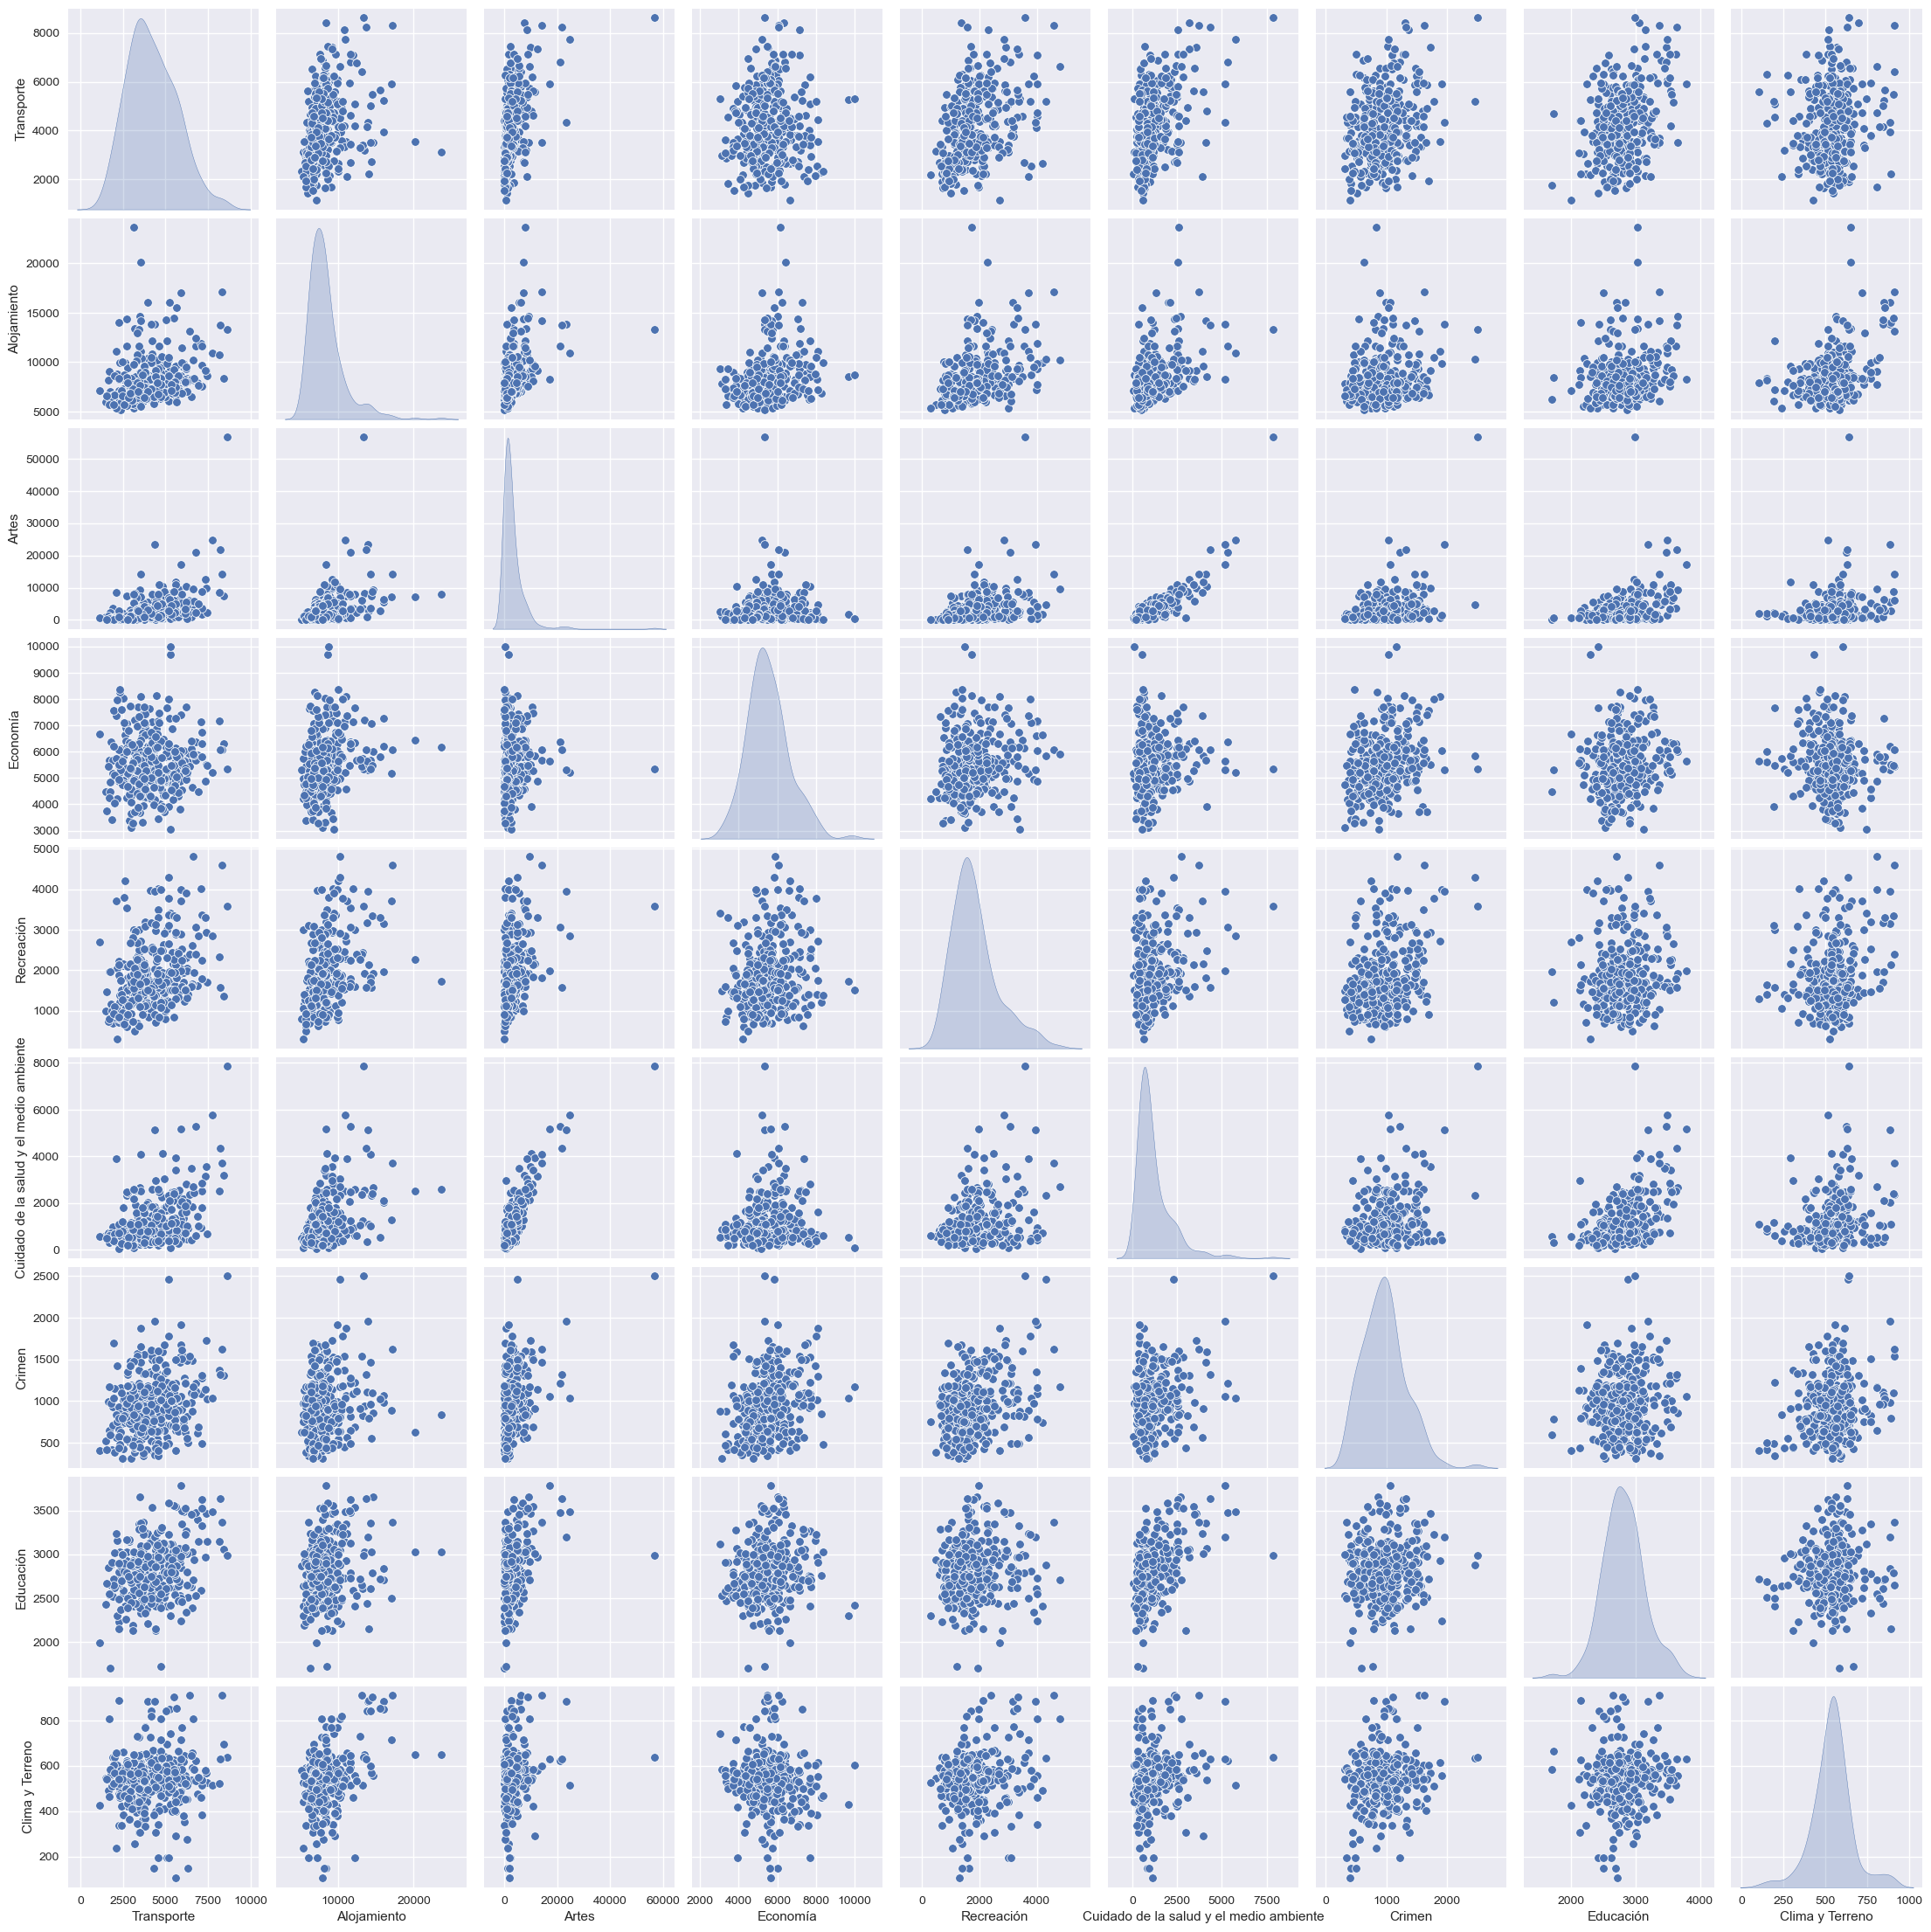

In [21]:
sns.pairplot(
    df_stage.loc[:, rank_frec_atributos],
    diag_kind='kde'
)

##### Importancia
Antes de aplicar un Análisis de Componentes Principales (PCA), es fundamental explorar las estadísticas descriptivas (media, mediana, desviación estándar, valores mínimos y máximos, entre otras) porque:

- **Detectan diferencias de escala:** El PCA es muy sensible a las unidades de medida. Si las variables están en magnitudes muy distintas, las de mayor rango dominarán la varianza y sesgarán los resultados. Este análisis nos avisa cuándo es necesario estandarizar.

- **Identifican valores atípicos:** Los outliers pueden influir de forma desproporcionada en la varianza, alterando la orientación de los componentes principales.

- **Revelan asimetrías o sesgos en la distribución:** Variables muy sesgadas pueden requerir transformaciones previas (por ejemplo, logarítmica o Box-Cox) para estabilizar la varianza.

- **Verifican la ausencia de datos faltantes:** Si existen valores nulos, la matriz de covarianzas podría dar eigenvalores negativos o cálculos no válidos.

En pocas palabras, analizar las estadísticas descriptivas asegura que el PCA se realice sobre datos consistentes, comparables y libres de problemas estructurales.

### 3.  Cálculo y selección de componentes principales.

Utilizando Álgebra Lineal, calcule los eigen valores y los eigen vectores, a partir de ellos obtenga los Componentes Principales. Tenga en cuenta de estandarizar las variables y explicar por qué es importante no omitir este paso. 

Luego, examine los valores propios para determinar cuántos componentes principales se deben considerar. Explique el criterio que utilizó para la elección y justifique su respuesta.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones).

In [22]:
# Estandarización de las variables
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)

# Cálculo de la matriz de covarianza
cov_matrix = np.cov(df_standardized, rowvar=False)

# Cálculo de eigenvalores y eigenvectores
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Ordenar los eigenvalores y eigenvectores en orden descendente
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Mostrar los eigenvalores
print("Eigenvalores:")
print(eigenvalues)

# Mostrar los eigenvectores
print("\nEigenvectores:")
print(eigenvectors)

# Determinar el número de componentes principales
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

Eigenvalores:
[3.418683 1.217677 1.144959 0.923725 0.755581 0.632484 0.494551 0.319008
 0.120769]

Eigenvectores:
[[ 2.064140e-01  2.178353e-01  6.899560e-01  1.373212e-01 -3.691499e-01
  -3.746047e-01  8.470577e-02  3.623083e-01  1.391351e-03]
 [ 3.565216e-01  2.506240e-01  2.081722e-01  5.118287e-01  2.334878e-01
   1.416398e-01  2.306386e-01 -6.138551e-01  1.360034e-02]
 [ 4.602146e-01 -2.994653e-01  7.324926e-03  1.470183e-02 -1.032405e-01
   3.738480e-01 -1.386761e-02  1.856761e-01 -7.163549e-01]
 [ 2.812984e-01  3.553423e-01 -1.851050e-01 -5.390505e-01 -5.239397e-01
  -8.092329e-02 -1.860646e-02 -4.300248e-01 -5.860846e-02]
 [ 3.511508e-01 -1.796045e-01 -1.463763e-01 -3.029037e-01  4.043485e-01
  -4.675918e-01  5.833910e-01  9.359866e-02  3.629453e-03]
 [ 2.752926e-01 -4.833821e-01 -2.297025e-01  3.354110e-01 -2.088191e-01
  -5.021698e-01 -4.261819e-01 -1.886676e-01  1.108402e-01]
 [ 4.630545e-01 -1.947899e-01  2.648430e-02 -1.010804e-01 -1.050976e-01
   4.618807e-01  2.152515e-0

In [23]:
# Umbrales
thresholds = [0.80, 0.90]

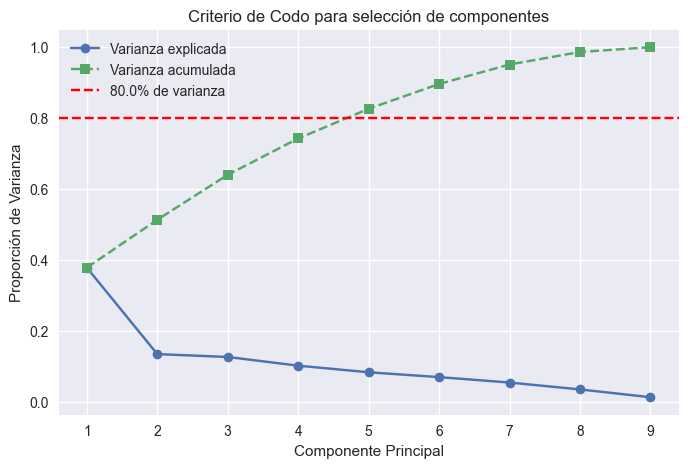

In [67]:
components = np.arange(1, len(eigenvalues) + 1)

# -------- 1. Gráfico de Codo (Scree Plot) --------
plt.figure(figsize=(8, 5))
plt.plot(components, explained_variance_ratio, 'o-', label='Varianza explicada')
plt.plot(components, cumulative_variance_ratio, 's--', label='Varianza acumulada')
plt.axhline(y=thresholds[0], color='red', linestyle='--', label=f'{thresholds[0]*100}% de varianza')
plt.xticks(components)
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza')
plt.title('Criterio de Codo para selección de componentes')
plt.legend()
plt.grid(True)

Para capturar al menos 80.0% de la varianza, Chebyshev requiere k ≈ 2.24


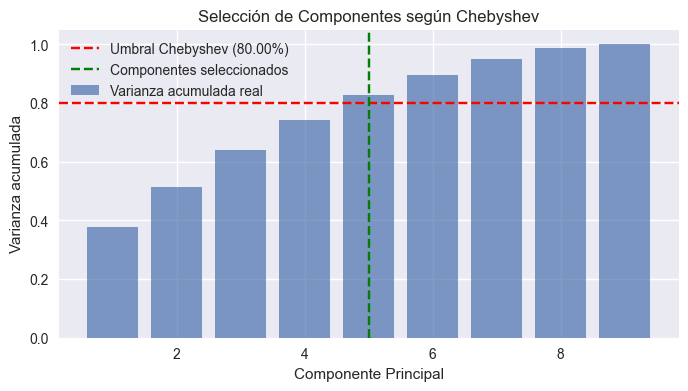

In [68]:
# -------- 2. Justificación con Desigualdad de Chebyshev --------
# Chebyshev asegura que al menos (1 - 1/k^2) de los datos estarán a <= k desviaciones estándar de la media
# Interpretación para PCA: si tomamos suficientes componentes para cubrir >= 1 - 1/k^2 de la varianza, 
# capturamos la "mayoría" de la información sin asumir normalidad.

k = np.sqrt(1 / (1 - thresholds[0]))  # 80% de varianza -> resolver para k
print(f"Para capturar al menos {thresholds[0]*100}% de la varianza, Chebyshev requiere k ≈ {k:.2f}")

# Visualización de la cobertura de Chebyshev
chebyshev_threshold = 1 - 1/(k**2)
plt.figure(figsize=(8, 4))
plt.bar(components, cumulative_variance_ratio, alpha=0.7, label='Varianza acumulada real')
plt.axhline(y=chebyshev_threshold, color='red', linestyle='--',
            label=f'Umbral Chebyshev ({chebyshev_threshold:.2%})')
plt.axvline(x=5, color='green', linestyle='--', label='Componentes seleccionados')
plt.ylim(0, 1.05)
plt.xlabel('Componente Principal')
plt.ylabel('Varianza acumulada')
plt.title('Selección de Componentes según Chebyshev')
plt.legend()
plt.grid(True)

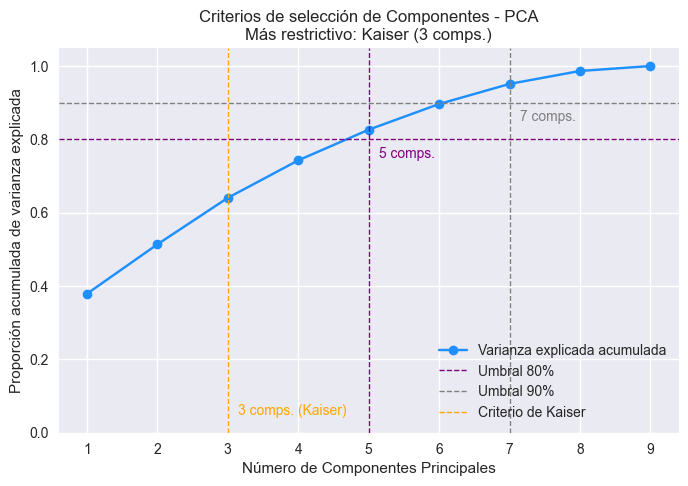

In [81]:
colors = ['purple', 'gray']
threshold_components = {}

plt.figure(figsize=(8, 5))

# Gráfica de codo
plt.plot(range(1, len(eigenvalues) + 1),
         cumulative_variance_ratio,
         marker='o', linestyle='-',
         color='dodgerblue', label='Varianza explicada acumulada')

# Líneas horizontales y verticales para cada umbral
for t, c in zip(thresholds, colors):
    num_components = np.argmax(cumulative_variance_ratio >= t) + 1
    threshold_components[f"Umbral {int(t*100)}%"] = num_components
    plt.axhline(y=t, color=c, linestyle='--', label=f'Umbral {int(t*100)}%', linewidth=1)
    plt.axvline(x=num_components, color=c, linestyle='--', linewidth=1)
    plt.text(num_components + 0.15, t - 0.05,
             f"{num_components} comps.",
             color=c, fontsize=10)

# Criterio de Kaiser: eigenvalores > 1
kaiser_components = np.sum(eigenvalues > 1)
threshold_components["Kaiser"] = kaiser_components
plt.axvline(x=kaiser_components, color='orange', linestyle='--', label='Criterio de Kaiser', linewidth=1)
plt.text(kaiser_components + 0.15, 0.05,
         f"{kaiser_components} comps. (Kaiser)",
         color='orange', fontsize=10)

# Determinar el criterio más restrictivo (menor número de componentes)
restrictive_criterion = min(threshold_components, key=threshold_components.get)
restrictive_value = threshold_components[restrictive_criterion]

plt.xlabel('Número de Componentes Principales')
plt.ylabel('Proporción acumulada de varianza explicada')
plt.title(f'Criterios de selección de Componentes - PCA\nMás restrictivo: {restrictive_criterion} ({restrictive_value} comps.)')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)

In [65]:
# Mostrar la proporción de varianza explicada acumulada
print("\nProporción acumulada de varianza explicada:")
print(cumulative_variance_ratio)

# Selección de componentes principales
num_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
print(f"\nNúmero de componentes principales seleccionados: {num_components}")


Proporción acumulada de varianza explicada:
[0.378699 0.513585 0.640416 0.742741 0.826439 0.896501 0.951284 0.986622
 1.      ]

Número de componentes principales seleccionados: 5


#### Interpretación de la selección de componentes principales

Antes de realizar el PCA, es **fundamental estandarizar las variables**. Esto se debe a que el PCA es sensible a las escalas: si las variables tienen magnitudes diferentes, las de mayor escala dominarán la varianza, afectando la orientación de los componentes principales. La estandarización garantiza que todas las variables contribuyan por igual al análisis, evitando sesgos y distorsiones.

En la gráfica de selección de componentes se muestran tres criterios comunes:


1. **Umbral del 80 % de varianza explicada** → Requiere **5 componentes** para superar el 80 % de varianza acumulada.  
2. **Umbral del 90 % de varianza explicada** → Requiere **7 componentes** para superar el 90 % de varianza acumulada.  
3. **Criterio de Kaiser** → Conserva únicamente los componentes con *eigenvalor* > 1. En este caso, los eigenvalores son:  
   [3.418683, 1.217677, 1.144959, 0.923725, 0.755581, 0.632484, 0.494551, 0.319008, 0.120769]

    Los que cumplen *eigenvalor* > 1 son:  
    - **PC1** → 3.418683  
    - **PC2** → 1.217677  
    - **PC3** → 1.144959  

    Esto confirma que, según el **Criterio de Kaiser**, se conservarían **3 componentes principales**.


El criterio **más restrictivo** (el que mantiene menos componentes) es el **Criterio de Kaiser**, que sugiere conservar **3 componentes principales**. Esto implica que el modelo de PCA se simplificaría bastante, reduciendo dimensionalidad y manteniendo solo las combinaciones lineales que superan la varianza promedio de una variable original.  

En la práctica, si el objetivo es **máxima reducción de dimensionalidad**, se optaría por el criterio de Kaiser (3 componentes). Si se busca **mayor capacidad de explicación de la varianza**, se podría elegir el umbral del 80 % o incluso el 90 %.  

En este caso, **se mantienen 5 componentes** porque alcanzan un 82.64 % de varianza acumulada, superando el 80 %. Aunque 6 componentes también estarían por debajo del 90 %, su varianza acumulada (89.65 %) no mejora lo suficiente como para justificar el aumento en la dimensionalidad, por lo que se elige el número más pequeño que cumple el umbral.  


### 4.  Interpretación de los componentes principales. 

Logró reducir la dimensión en el ejercicio anterior? Si lo hizo, pueden los pesos obtenidos identificar dimensiones menores de los datos? Provea una interpretación a estas dimensiones, para ello puede utilizar gráficas y/o tablas.

#### Interpretación de los Componentes Principales
En el ejercicio anterior, logramos reducir la dimensión de las variables originales de 9 a 5 componentes principales, utilizando el criterio de proporción acumulada de varianza explicada (80%). Esto significa que los 5 componentes seleccionados explican el 82.64% de la variabilidad total de los datos, lo cual es suficiente para representar la varianza de los datos en gran medida.

Los pesos obtenidos (eigenvectores) permiten identificar las dimensiones menores de los datos. Cada componente principal es una combinación lineal de las variables originales, y los coeficientes asociados a cada variable indican su contribución a dicho componente. Esto facilita la interpretación de las dimensiones reducidas.

In [27]:
# Utilice este espacio para escribir el código.

df_componentes = pd.DataFrame(
    eigenvectors[:5,:],
    columns=df.columns,
    index=[f'PC{i+1}' for i in range(eigenvectors[:5,:].shape[0])]
)
df_componentes.head()

,Clima y Terreno,Alojamiento,Cuidado de la salud y el medio ambiente,Crimen,Transporte,Educación,Artes,Recreación,Economía
PC1,0.206414,0.217835,0.689956,0.137321,-0.369150,-0.374605,0.084706,0.362308,0.001391
PC2,0.356522,0.250624,0.208172,0.511829,0.233488,0.141640,0.230639,-0.613855,0.013600
PC3,0.460215,-0.299465,0.007325,0.014702,-0.103241,0.373848,-0.013868,0.185676,-0.716355
PC4,0.281298,0.355342,-0.185105,-0.539050,-0.523940,-0.080923,-0.018606,-0.430025,-0.058608
PC5,0.351151,-0.179604,-0.146376,-0.302904,0.404348,-0.467592,0.583391,0.093599,0.003629


##### Interpretación de las Dimensiones
1. **Primer Componente Principal (PC1)**: Para este componente, variables como cuidado de la salud y el medio ambiente y Recreación tienen una contribución significativa y positiva; variables como Transporte y Educación tienen una influencia moderada pero negativa y finalmente, variables como economía y artes su contribución es casi nula. Es decir, acá tendremos seguramente agrupaciones con ciudades de buena calificación en cuidado de la salud y el medio ambiente y menor calificación en transporte.
2. **Segundo Componente Principal (PC2)**: Para este componente, variables como Crimen y Clima y terreno tienen una contribución significativa y positiva; variables como Recreación tienen una influencia significativa pero negativa y finalmente, variables como economía su contribución es casi nula. Es decir, acá tendremos seguramente agrupaciones con ciudades de mala calificación en Crimen y mala calificación en Recreación.
3. **Tercer Componente Principal (PC3)**: Para este componente, variables como Clima y terreno tienen una contribución significativa y positiva; variables como Economía tienen una influencia significativa pero negativa y finalmente, variables como Cuidado de la salud y el medio ambiente y Crimen su contribución es casi nula. Es decir, acá tendremos seguramente agrupaciones con ciudades de buena calificación en Clima y terreno y menor calificación en Economía.
4. **Cuarto Componente Principal (PC4)**: Para este componente, variables como Alojamiento tienen una contribución significativa y positiva; variables como Crimen tienen una influencia significativa pero negativa y finalmente, variables como Artes su contribución es casi nula. Es decir, acá tendremos seguramente agrupaciones con ciudades de baja calificación en Alojamiento y buena calificación en Crimen.
5. **Quinto Componente Principal (PC5)**: Para este componente, variables como Artes tienen una contribución significativa y positiva; variables como Educación tienen una influencia significativa pero negativa y finalmente, variables como Economía su contribución es casi nula. Es decir, acá tendremos seguramente agrupaciones con ciudades de buena calificación en Artes y baja calificación en Educación.


##### Visualización
Para facilitar la interpretación, se procede a la construcción del modelo con la librería PCA, la cual nos ayudará a confirmar la elección de los componentes principales, y a su vez el paquete biplot nos permitirá realizar un análisis más completo de las dimensiones frente a los componentes principales. Para esta parte del análisis gráfico, nos enfocaremos únicamente en los 2 componentes principales que explican el 51.35% de la varianza pero que nos ayudan a entender el impacto de los pesos sobre las dimensiones.


In [29]:
model = pca(n_components=2)
ciudades = model.fit_transform(df_standardized, verbose=False)
ciudades['loadings']

,1,2,3,4,5,6,7,8,9
PC1,0.206414,0.356522,0.460215,0.281298,0.351151,0.275293,0.463054,0.327888,0.135412
PC2,-0.217835,-0.250624,0.299465,-0.355342,0.179604,0.483382,0.194790,-0.384475,-0.471283


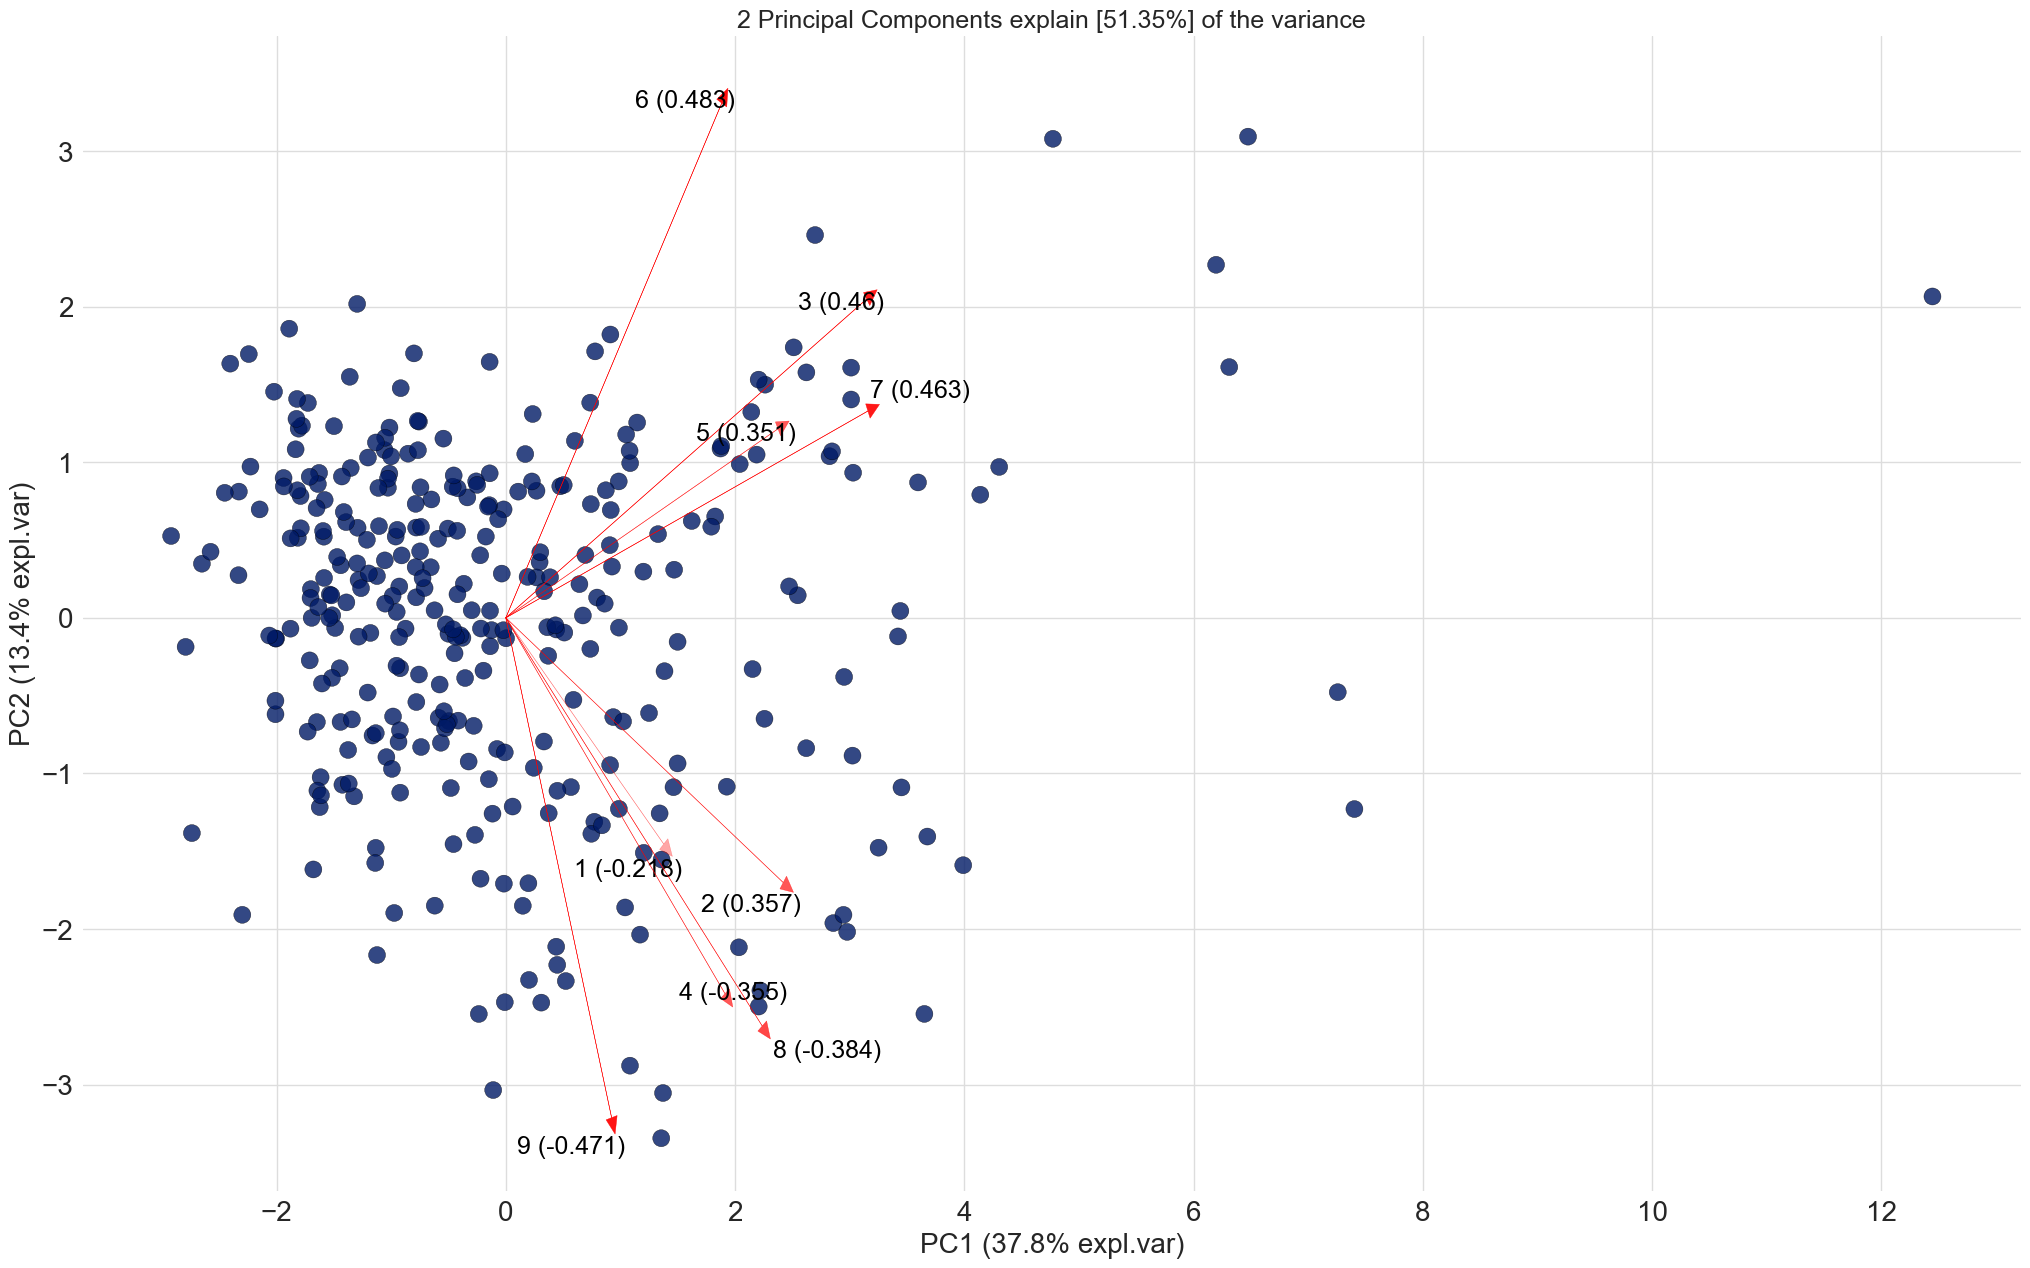

In [31]:
fig, ax = model.biplot(legend=False, color_arrow="red", arrowdict={'color_text':"black"})

##### Conclusión
La reducción de dimensiones permite simplificar el análisis de los datos, identificando patrones y relaciones entre las ciudades de manera más clara. Las dimensiones obtenidas ofrecen una perspectiva más manejable para interpretar la calidad de vida en las ciudades, destacando los aspectos más relevantes de cada una.

A partir del gráfico biplot de la libreria pca podemos concluir lo siguiente:
1. A partir de una reducción de dimensionalidad a solo 2 componentes, se puede explicar la mitad de la varianza de los datos
2. Las variables Educación y Economía tienen una marcada proyección sobre el componente principal 2 con loadings de 0.483 y -0.471 respectivamente
3. Las variables Cuidado de la salud y el medio ambiente y Artes tienen una marcada proyección sobre el componente principal 1 con loadings de 0.46 y 0.463 respectivamente
4. Dimensiones como Clima y Terreno	 y Transporte se pueden catalogar como dimensiones menores, ya que explican en menor medida la varianza de los datos
5. Una gran cantidad de puntos azules (Ciudades) tienden a estar agrupados hacia el punto (0,0) del gráfico, lo que nos da a entender que las ciudades en su mayoría suelen tener puntajes similares


### 5.   Detección de ciudades inusuales.

A partir de los Componentes Principales identifique las 5 ciudades calidad de vida inusualmente alta. En la distribución de calidad de vida  de la muestra que tan inusuales son? Cuáles son las dimensiones que hacen que estas ciudades tengan esta calidad de vida inusual?

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones).

In [31]:
# Proyección de los datos en el espacio de los componentes principales
principal_components = df_standardized @ eigenvectors[:, :num_components]

# Calcular la puntuación total de calidad de vida como la suma ponderada de los componentes principales
weights = explained_variance_ratio[:num_components]
scores = principal_components @ weights

# Identificar las 5 ciudades con las puntuaciones más altas
df_scores = pd.DataFrame(scores, index=df.index, columns=["Score"])
top_cities = df_scores.nlargest(5, "Score")

print("Ciudades con calidad de vida inusualmente alta:")
print(top_cities)

# Obtener las posiciones numéricas de las ciudades seleccionadas
indices = [df.index.get_loc(city) for city in top_cities.index]

# Seleccionar los componentes principales correspondientes
top_cities_components = principal_components[indices, :]

# Crear el DataFrame con los componentes principales de las ciudades seleccionadas
df_top_cities_components = pd.DataFrame(
    top_cities_components,
    index=top_cities.index,
    columns=[f"PC{i+1}" for i in range(num_components)]
)

print("\nContribución de los componentes principales para las ciudades seleccionadas:")
print(df_top_cities_components)

Ciudades con calidad de vida inusualmente alta:
                              Score
Ciudad                             
New-York,NY                3.968961
San-Francisco,CA           3.288833
Los-Angeles,Long-Beach,CA  2.881151
Boston,MA                  2.140208
Stamford,CT                2.139382

Contribución de los componentes principales para las ciudades seleccionadas:
                                 PC1       PC2       PC3       PC4       PC5
Ciudad                                                                      
New-York,NY                12.445179 -2.064887  0.210083 -3.430722 -1.685713
San-Francisco,CA            7.402662  1.228869  1.694329  0.406496  0.755162
Los-Angeles,Long-Beach,CA   7.257344  0.477878  2.054085 -0.522492 -1.657330
Boston,MA                   6.310655 -1.611192 -0.363214  0.276460 -0.173549
Stamford,CT                 3.451349  1.089921  1.659924  4.247819  0.479805


En general, todas las ciudades destacan mucho por **PC1**, relacionado con la buena calificación en **cuidado de la salud y el medio ambiente** junto con **recreación**. Esto las hace destacar como ciudades con **calidad de vida inusualmente alta**.

A continuación, se describen el resto de componentes y sus elementos para cada una de las ciudades:

- **New-York, NY:** realmente solo destaca por el componente **PC1**, pues tiene el valor más alto en este componente entre las ciudades.
- **San-Francisco, CA:** el segundo componente más relevante es **PC3**, indicando una leve relevancia en *clima y terreno*.
- **Los-Angeles, Long-Beach, CA:** el segundo componente más relevante es **PC3**, indicando una leve relevancia en *clima y terreno*.
- **Boston, MA:** principalmente destaca por **PC1** y una escasa participación del resto de componentes.
- **Stamford, CT:** además de **PC1**, muestra fortaleza en **PC4**, donde la dimensión *alojamiento* es la predominante.

**Conclusión:** la mayoría de las ciudades están en el *top 5* debido al **PC1**, relacionado con la buena calificación en **cuidado de la salud y el medio ambiente** junto con **recreación**. Existen otras dimensiones que pueden aportar en menor proporción, destacando el **PC4** en la dimensión *alojamiento* principalmente para la ciudad de Stamford.
